In [1]:
import numpy as np
import pandas as pd
from torch import nn
from phmd import datasets
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, RobustScaler
from scipy.stats import kurtosis
from scipy.fft import fft
from scipy.fft import fft, fftfreq
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
from tqdm import tqdm

/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [2]:
def early_prediction_score(y_true, y_pred, alpha=0.5):
    errors = y_pred - y_true
    # Heavier penalty for late predictions
    weights = np.where(errors < 0, alpha, 1)
    return np.mean(weights * errors**2)

In [3]:
TRAIN_BEARINGS = {
    1: [
        '1_1',
        # '1_2',
    ],
    2: [
        '2_1',
        '2_2',
    ],
    3: [
        '3_1',
        '3_2',
    ]
}

TEST_BEARINGS = {
    1: [
        '1_3',
        '1_4',
        '1_5',
        '1_6',
        '1_7',
    ],
    2: [
        '2_3',
        '2_4',
        '2_5',
        '2_6',
        '2_7',
    ],
    3: [
        '3_3',
    ]
}

In [4]:
dataset = datasets.Dataset('PRONOSTIA')
tasks = dataset['rul']
df = tasks.load()

Remember to cite the original publisher dataset:
	@inproceedings{nectoux2012pronostia,    
	    title={PRONOSTIA: An experimental platform for bearings accelerated degradation tests.},    
	    author={Nectoux, Patrick and Gouriveau, Rafael and Medjaher, Kamal and Ramasso, Emmanuel and Chebel-Morello, Brigitte and Zerhouni, Noureddine and Varnier, Christophe},    
	    booktitle={IEEE International Conference on Prognostics and Health Management, PHM'12.},    
	    pages={1--8},    
	    year={2012},    
	    organization={IEEE Catalog Number: CPF12PHM-CDR}    
	}
You can download the dataset manually from:  https://www.nasa.gov/intelligent-systems-division/discovery-and-systems-health/pcoe/pcoe-data-set-repository/

** If you find this tool useful, please cite our SoftwareX paper: 
	Solís-Martín, David, Juan Galán-Páez, and Joaquín Borrego-Díaz. "PHMD: An easy data access tool for prognosis and health management datasets." SoftwareX 29 (2025): 102039.



Reading Bearing3_3: 100%|██████████| 13959/13959 [00:35<00:00, 390.76it/s]
INFO:root:Read in 57.81956434249878 seconds


In [5]:
# train
df[0]['unit'].unique()

array(['1_1', '1_2', '2_1', '2_2', '3_1', '3_2'], dtype=object)

In [6]:
df[0].head(5)

,rul,V_acc,H_acc,unit
0,28029,-0.146,0.552,1_1
1,28029,-0.480,0.501,1_1
2,28029,0.435,0.138,1_1
3,28029,0.240,-0.423,1_1
4,28029,0.020,-0.802,1_1


In [7]:
# test
df[1]['unit'].unique()

array(['1_3', '1_4', '1_5', '1_6', '1_7', '2_3', '2_4', '2_5', '2_6',
       '2_7', '3_3'], dtype=object)

In [8]:
df[0][df[0]['unit'].isin(TRAIN_BEARINGS[1])]['unit']

0          1_1
1          1_1
2          1_1
3          1_1
4          1_1
          ... 
7175675    1_1
7175676    1_1
7175677    1_1
7175678    1_1
7175679    1_1
Name: unit, Length: 7175680, dtype: object

In [9]:
df[0][df[0]['unit'].isin(TRAIN_BEARINGS[1])]

,rul,V_acc,H_acc,unit
0,28029,-0.146,0.552,1_1
1,28029,-0.480,0.501,1_1
2,28029,0.435,0.138,1_1
3,28029,0.240,-0.423,1_1
4,28029,0.020,-0.802,1_1
...,...,...,...,...
7175675,0,2.129,-3.353,1_1
7175676,0,-2.299,-2.868,1_1
7175677,0,-1.844,-5.507,1_1
7175678,0,2.146,-3.578,1_1


In [10]:
df[1][df[1]['unit'].isin(TEST_BEARINGS[1])]

,rul,V_acc,H_acc,unit
0,23749,0.044,0.092,1_3
1,23749,0.432,-0.025,1_3
2,23749,0.008,-0.104,1_3
3,23749,-0.264,0.056,1_3
4,23749,-0.195,0.074,1_3
...,...,...,...,...
3845115,7570,-0.013,0.481,1_7
3845116,7570,-0.272,0.191,1_7
3845117,7570,0.466,0.250,1_7
3845118,7570,-0.582,0.001,1_7


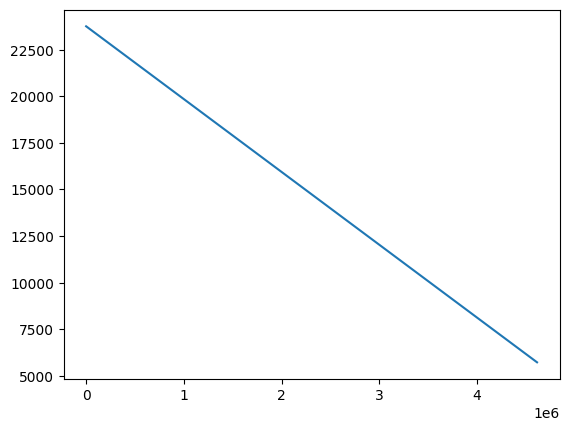

In [11]:
plt.plot(df[1][df[1]['unit'] == '1_3']['rul'])

In [12]:
# sns.kdeplot(df[0][df[0]['unit'] == '1_1']['H_acc'], label='Train')
# sns.kdeplot(test_features['h_RMS'], label='Test')
# plt.legend(); plt.show()

In [370]:
class BearingDataset(torch.utils.data.Dataset):
    def __init__(self, df, window_size=2560, step=2560 // 2):
        self.windows = []
        self.ruls = []
        
        # Create sequences
        for unit, group in df.groupby('unit'):
            h_acc =  group['H_acc'].transform(
                lambda x: (x - x.mean()) / (x.std() + 1e-8)
            )
            v_acc =  group['V_acc'].transform(
                lambda x: (x - x.mean()) / (x.std() + 1e-8)
            )

            rul = group['rul'].transform(lambda x: x / x.max())

            for i in range(0, len(group) - window_size, step):

                self.windows.append(np.stack([
                    h_acc[i:i+window_size], 
                    v_acc[i:i+window_size]
                ], axis=1))
                self.ruls.append(rul.values[i+window_size-1])

    def __len__(self):
        return len(self.windows)
    
    def __getitem__(self, idx):
        return torch.FloatTensor(self.windows[idx]), torch.FloatTensor([self.ruls[idx]])
    
train_dataset = BearingDataset(
    # [b for state in TRAIN_BEARINGS for b in TRAIN_BEARINGS[state]]
    df=df[0][df[0]['unit'].isin(['1_1'])],
)

test_dataset = BearingDataset(
    df=df[1][df[1]['unit'] == '1_3'],
)

val_dataset = BearingDataset(
    df=df[0][df[0]['unit'] == '1_2'],
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

In [371]:
len(train_dataset)

5604

In [412]:
class BearingCNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        # Feature extractor
        self.features = torch.nn.Sequential(
            # Layer 1: Wide receptive field
            torch.nn.Conv1d(2, 64, kernel_size=51, padding=25),  # (B, 2, 2560) -> (B, 64, 2560)
            torch.nn.BatchNorm1d(64),
            torch.nn.LeakyReLU(0.1),
            torch.nn.MaxPool1d(4, stride=2),  # -> (B, 64, 1278)
            
            # Layer 2: Mid-range features
            torch.nn.Conv1d(64, 128, kernel_size=25, padding=12),  # -> (B, 128, 1278)
            torch.nn.BatchNorm1d(128),
            torch.nn.LeakyReLU(0.1),
            torch.nn.MaxPool1d(4, stride=2),  # -> (B, 128, 637)
            
            # Layer 3: Local features
            torch.nn.Conv1d(128, 256, kernel_size=10, padding=5),  # -> (B, 256, 637)
            torch.nn.BatchNorm1d(256),
            torch.nn.LeakyReLU(0.1),
            torch.nn.AdaptiveAvgPool1d(1)  # -> (B, 256, 1)
        )
        
        # Regressor (fixed input dim)
        self.regressor = torch.nn.Sequential(
            torch.nn.Linear(256, 128),
            torch.nn.LayerNorm(128),  # Better for regression
            torch.nn.LeakyReLU(0.1),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(128, 1),
            # torch.nn.Sigmoid(),
            # Removed Sigmoid() for regression
        )

        # self.fc = torch.nn.Linear(128, 1)

        # with torch.no_grad():
        #     self.fc.weight.data = -torch.abs(self.fc.weight.data)
        #     self.fc.bias.data.fill_(1.0)  # Start predictions near 1.0
    
    def forward(self, x):
        # Input: (B, 2560, 2)
        x = x.permute(0, 2, 1)  # -> (B, 2, 2560)
        x = self.features(x)     # -> (B, 256, 1)
        x = x.squeeze(-1)        # -> (B, 256)
        x = self.regressor(x)  # -> (B,)
        return x

model = BearingCNN()

print(model)

BearingCNN(
  (features): Sequential(
    (0): Conv1d(2, 64, kernel_size=(51,), stride=(1,), padding=(25,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): MaxPool1d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(64, 128, kernel_size=(25,), stride=(1,), padding=(12,))
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.1)
    (7): MaxPool1d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv1d(128, 256, kernel_size=(10,), stride=(1,), padding=(5,))
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.1)
    (11): AdaptiveAvgPool1d(output_size=1)
  )
  (regressor): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): LayerNorm((128,), eps=1e-05, elementwise_affine=

In [413]:
class LogCoshLoss(nn.Module):
    def forward(self, y_pred, y_true):
        return torch.mean(torch.log(torch.cosh(y_pred - y_true)))

def weighted_mse_loss(y_pred, y_true):
    alpha=2.0
    error = y_pred - y_true
    weights = torch.where(error < 0, alpha, 1.0)  # Heavier penalty for underestimating RUL
    return torch.mean(weights * (error ** 2))

def r2_score_loss(y_pred, y_true):
    # Calculate R² (Coefficient of Determination)
    ss_res = torch.sum((y_true - y_pred) ** 2)
    ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2)
    r2 = 1 - (ss_res / (ss_tot + 1e-8))  # Avoid division by zero
    return -r2  # Minimize this (equivalent to maximizing R²)

def hybrid_r2_mse_loss(y_pred, y_true,):
    # alpha=0.5
    alpha = 0.8
    mse = torch.mean((y_pred - y_true) ** 2)
    r2 = r2_score_loss(y_pred, y_true)  # Returns -R²
    return alpha * mse + (1 - alpha) * r2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = hybrid_r2_mse_loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

def train(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    device,
    epochs,
):
    train_r2 = []
    train_mae = []
    train_mse = []
    train_rmse = []
    train_loss = []

    val_r2 = []
    val_mae = []
    val_mse = []
    val_rmse = []
    val_loss = []

    best_r2 = -float('inf')

    for epoch in range(epochs):
        model.train()

        epoch_train_loss = 0
        epoch_train_preds = []
        epoch_train_targets = []

        for X_batch, y_batch in tqdm(train_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            y_pred = model(X_batch).flatten()

            epoch_train_preds.append(y_pred)
            epoch_train_targets.append(y_batch)

            loss = criterion(y_pred, y_batch)
            
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item()
        
        train_preds = torch.cat(epoch_train_preds).cpu().detach().numpy()
        train_targets = torch.cat(epoch_train_targets).cpu().detach().numpy()
        
        epoch_train_r2 = r2_score(train_targets, train_preds)
        epoch_train_mae = mean_absolute_error(train_targets, train_preds)
        epoch_train_mse = mean_squared_error(train_targets, train_preds)
        epoch_train_rmse = np.sqrt(epoch_train_mse)
        epoch_train_loss = epoch_train_loss/len(train_loader)
        
        train_r2.append(epoch_train_r2)
        train_mae.append(epoch_train_mae)
        train_mse.append(epoch_train_mse)
        train_rmse.append(epoch_train_rmse)
        train_loss.append(epoch_train_loss)
    
        print(
            f'Epoch {epoch + 1}: Train Loss {epoch_train_loss:.4f}, '
                + f'Train R2 = {epoch_train_r2:.3f}, '
                + f'Train RMSE = {epoch_train_rmse:.3f}, '
                + f'Train MSE = {epoch_train_mse:.3f}, '
                + f'Train MAE = {epoch_train_mae:.3f}'
                # + f'Train EPS = {epoch_train_eps:.3f}'
        )


        model.eval()

        epoch_val_loss = 0
        epoch_val_preds = []
        epoch_val_targets = []

        with torch.no_grad():
            for X_val, y_val in tqdm(val_loader, desc=f'Epoch {epoch + 1} Val'):
                X_val, y_val = X_val.to(device), y_val.to(device)

                y_pred = model(X_val).flatten()

                epoch_val_preds.append(y_pred)
                epoch_val_targets.append(y_val)
                
                epoch_val_loss += criterion(y_pred, y_val).item()

        val_preds = torch.cat(epoch_val_preds).cpu().detach().numpy()
        val_targets = torch.cat(epoch_val_targets).cpu().detach().numpy()
        
        epoch_val_r2 = r2_score(val_targets, val_preds)
        epoch_val_mae = mean_absolute_error(val_targets, val_preds)
        epoch_val_mse = mean_squared_error(val_targets, val_preds)
        epoch_val_rmse = np.sqrt(epoch_val_mse)
        epoch_val_loss = epoch_val_loss/len(val_loader)
        scheduler.step(epoch_val_loss)
        
        val_r2.append(epoch_val_r2)
        val_mae.append(epoch_val_mae)
        val_mse.append(epoch_val_mse)
        val_rmse.append(epoch_val_rmse)
        val_loss.append(epoch_val_loss)

        if val_r2[-1] > best_r2:
            best_r2 = val_r2[-1]
            torch.save(model.state_dict(), 'best_r2_model.pth')

        print(
            f'Epoch {epoch + 1}: Val Loss {epoch_val_loss:.4f}, '
                + f'Val R2 = {epoch_val_r2:.3f}, '
                + f'Val RMSE = {epoch_val_rmse:.3f}, '
                + f'Val MSE = {epoch_val_mse:.3f}, '
                + f'Val MAE = {epoch_val_mae:.3f}'
        ) 

    return {
        'train_loss': train_loss,
        'train_r2': train_r2,
        'train_mae': train_mae,
        'train_mse': train_mse,
        'train_rmse': train_rmse,
        'val_loss': val_loss,
        'val_r2': val_r2,
        'val_mae': val_mae,
        'val_mse': val_mse,
        'val_rmse': val_rmse,
    }

In [414]:
train_results = train(model, train_loader, val_loader, optimizer, criterion, device, 50)

train_results

100%|██████████| 176/176 [00:04<00:00, 42.00it/s]


Epoch 1: Train Loss 71411.4770, Train R2 = 0.635, Train RMSE = 0.174, Train MSE = 0.030, Train MAE = 0.103


Epoch 1 Val: 100%|██████████| 55/55 [00:00<00:00, 166.58it/s]


Epoch 1: Val Loss 75271.1224, Val R2 = -3.020, Val RMSE = 0.578, Val MSE = 0.334, Val MAE = 0.501


100%|██████████| 176/176 [00:04<00:00, 41.86it/s]


Epoch 2: Train Loss 72934.3530, Train R2 = 0.628, Train RMSE = 0.176, Train MSE = 0.031, Train MAE = 0.094


Epoch 2 Val: 100%|██████████| 55/55 [00:00<00:00, 164.05it/s]


Epoch 2: Val Loss 70061.1295, Val R2 = -2.741, Val RMSE = 0.558, Val MSE = 0.311, Val MAE = 0.478


100%|██████████| 176/176 [00:04<00:00, 41.69it/s]


Epoch 3: Train Loss 92069.4452, Train R2 = 0.532, Train RMSE = 0.198, Train MSE = 0.039, Train MAE = 0.105


Epoch 3 Val: 100%|██████████| 55/55 [00:00<00:00, 163.07it/s]


Epoch 3: Val Loss 73976.6144, Val R2 = -2.951, Val RMSE = 0.573, Val MSE = 0.329, Val MAE = 0.495


100%|██████████| 176/176 [00:04<00:00, 40.74it/s]


Epoch 4: Train Loss 92761.1194, Train R2 = 0.526, Train RMSE = 0.199, Train MSE = 0.039, Train MAE = 0.105


Epoch 4 Val: 100%|██████████| 55/55 [00:00<00:00, 156.26it/s]


Epoch 4: Val Loss 67710.7812, Val R2 = -2.616, Val RMSE = 0.548, Val MSE = 0.301, Val MAE = 0.469


100%|██████████| 176/176 [00:04<00:00, 37.25it/s]


Epoch 5: Train Loss 95194.0361, Train R2 = 0.517, Train RMSE = 0.201, Train MSE = 0.040, Train MAE = 0.109


Epoch 5 Val: 100%|██████████| 55/55 [00:00<00:00, 153.99it/s]


Epoch 5: Val Loss 74545.3920, Val R2 = -2.980, Val RMSE = 0.575, Val MSE = 0.331, Val MAE = 0.499


100%|██████████| 176/176 [00:04<00:00, 35.81it/s]


Epoch 6: Train Loss 85718.6375, Train R2 = 0.563, Train RMSE = 0.191, Train MSE = 0.036, Train MAE = 0.104


Epoch 6 Val: 100%|██████████| 55/55 [00:00<00:00, 148.40it/s]


Epoch 6: Val Loss 86453.3779, Val R2 = -3.616, Val RMSE = 0.620, Val MSE = 0.384, Val MAE = 0.548


100%|██████████| 176/176 [00:05<00:00, 34.08it/s]


Epoch 7: Train Loss 102784.1902, Train R2 = 0.476, Train RMSE = 0.209, Train MSE = 0.044, Train MAE = 0.112


Epoch 7 Val: 100%|██████████| 55/55 [00:00<00:00, 144.44it/s]


Epoch 7: Val Loss 82379.4172, Val R2 = -3.398, Val RMSE = 0.605, Val MSE = 0.366, Val MAE = 0.534


100%|██████████| 176/176 [00:05<00:00, 32.14it/s]


Epoch 8: Train Loss 110154.9261, Train R2 = 0.439, Train RMSE = 0.216, Train MSE = 0.047, Train MAE = 0.118


Epoch 8 Val: 100%|██████████| 55/55 [00:00<00:00, 130.67it/s]


Epoch 8: Val Loss 67264.7249, Val R2 = -2.588, Val RMSE = 0.546, Val MSE = 0.298, Val MAE = 0.468


100%|██████████| 176/176 [00:05<00:00, 31.99it/s]


Epoch 9: Train Loss 114369.5527, Train R2 = 0.416, Train RMSE = 0.221, Train MSE = 0.049, Train MAE = 0.120


Epoch 9 Val: 100%|██████████| 55/55 [00:00<00:00, 131.36it/s]


Epoch 9: Val Loss 85010.2275, Val R2 = -3.540, Val RMSE = 0.614, Val MSE = 0.378, Val MAE = 0.541


100%|██████████| 176/176 [00:05<00:00, 32.15it/s]


Epoch 10: Train Loss 110057.5530, Train R2 = 0.439, Train RMSE = 0.216, Train MSE = 0.047, Train MAE = 0.120


Epoch 10 Val: 100%|██████████| 55/55 [00:00<00:00, 124.41it/s]


Epoch 10: Val Loss 56990.9178, Val R2 = -2.038, Val RMSE = 0.503, Val MSE = 0.253, Val MAE = 0.422


100%|██████████| 176/176 [00:05<00:00, 32.12it/s]


Epoch 11: Train Loss 118108.0901, Train R2 = 0.398, Train RMSE = 0.224, Train MSE = 0.050, Train MAE = 0.131


Epoch 11 Val: 100%|██████████| 55/55 [00:00<00:00, 124.68it/s]


Epoch 11: Val Loss 69691.8075, Val R2 = -2.720, Val RMSE = 0.556, Val MSE = 0.309, Val MAE = 0.476


100%|██████████| 176/176 [00:05<00:00, 31.56it/s]


Epoch 12: Train Loss 130571.2510, Train R2 = 0.340, Train RMSE = 0.234, Train MSE = 0.055, Train MAE = 0.142


Epoch 12 Val: 100%|██████████| 55/55 [00:00<00:00, 125.57it/s]


Epoch 12: Val Loss 51681.7644, Val R2 = -1.750, Val RMSE = 0.478, Val MSE = 0.229, Val MAE = 0.395


100%|██████████| 176/176 [00:05<00:00, 30.19it/s]


Epoch 13: Train Loss 133551.7448, Train R2 = 0.317, Train RMSE = 0.238, Train MSE = 0.057, Train MAE = 0.144


Epoch 13 Val: 100%|██████████| 55/55 [00:00<00:00, 124.87it/s]


Epoch 13: Val Loss 58931.0143, Val R2 = -2.141, Val RMSE = 0.511, Val MSE = 0.261, Val MAE = 0.429


100%|██████████| 176/176 [00:06<00:00, 28.76it/s]


Epoch 14: Train Loss 129698.5244, Train R2 = 0.339, Train RMSE = 0.235, Train MSE = 0.055, Train MAE = 0.144


Epoch 14 Val: 100%|██████████| 55/55 [00:00<00:00, 112.81it/s]


Epoch 14: Val Loss 65276.9060, Val R2 = -2.472, Val RMSE = 0.537, Val MSE = 0.289, Val MAE = 0.462


100%|██████████| 176/176 [00:06<00:00, 27.59it/s]


Epoch 15: Train Loss 116771.2280, Train R2 = 0.404, Train RMSE = 0.223, Train MSE = 0.050, Train MAE = 0.136


Epoch 15 Val: 100%|██████████| 55/55 [00:00<00:00, 122.89it/s]


Epoch 15: Val Loss 66153.6956, Val R2 = -2.529, Val RMSE = 0.542, Val MSE = 0.293, Val MAE = 0.463


100%|██████████| 176/176 [00:06<00:00, 26.04it/s]


Epoch 16: Train Loss 111719.3397, Train R2 = 0.435, Train RMSE = 0.217, Train MSE = 0.047, Train MAE = 0.134


Epoch 16 Val: 100%|██████████| 55/55 [00:00<00:00, 118.85it/s]


Epoch 16: Val Loss 71915.1162, Val R2 = -2.828, Val RMSE = 0.564, Val MSE = 0.318, Val MAE = 0.492


100%|██████████| 176/176 [00:06<00:00, 26.30it/s]


Epoch 17: Train Loss 112538.1109, Train R2 = 0.427, Train RMSE = 0.218, Train MSE = 0.048, Train MAE = 0.139


Epoch 17 Val: 100%|██████████| 55/55 [00:00<00:00, 117.24it/s]


Epoch 17: Val Loss 43940.1102, Val R2 = -1.325, Val RMSE = 0.440, Val MSE = 0.193, Val MAE = 0.365


100%|██████████| 176/176 [00:06<00:00, 25.42it/s]


Epoch 18: Train Loss 92956.0246, Train R2 = 0.528, Train RMSE = 0.198, Train MSE = 0.039, Train MAE = 0.124


Epoch 18 Val: 100%|██████████| 55/55 [00:00<00:00, 108.72it/s]


Epoch 18: Val Loss 40503.1014, Val R2 = -1.123, Val RMSE = 0.420, Val MSE = 0.177, Val MAE = 0.351


100%|██████████| 176/176 [00:07<00:00, 24.22it/s]


Epoch 19: Train Loss 80638.4405, Train R2 = 0.607, Train RMSE = 0.181, Train MSE = 0.033, Train MAE = 0.118


Epoch 19 Val: 100%|██████████| 55/55 [00:00<00:00, 117.23it/s]


Epoch 19: Val Loss 36147.4063, Val R2 = -0.826, Val RMSE = 0.390, Val MSE = 0.152, Val MAE = 0.321


100%|██████████| 176/176 [00:07<00:00, 23.66it/s]


Epoch 20: Train Loss 88870.0536, Train R2 = 0.564, Train RMSE = 0.190, Train MSE = 0.036, Train MAE = 0.124


Epoch 20 Val: 100%|██████████| 55/55 [00:00<00:00, 112.46it/s]


Epoch 20: Val Loss 19696.9631, Val R2 = 0.082, Val RMSE = 0.276, Val MSE = 0.076, Val MAE = 0.238


100%|██████████| 176/176 [00:07<00:00, 24.19it/s]


Epoch 21: Train Loss 101010.5688, Train R2 = 0.500, Train RMSE = 0.204, Train MSE = 0.042, Train MAE = 0.129


Epoch 21 Val: 100%|██████████| 55/55 [00:00<00:00, 98.49it/s]


Epoch 21: Val Loss 34937.1708, Val R2 = -0.739, Val RMSE = 0.380, Val MSE = 0.145, Val MAE = 0.318


100%|██████████| 176/176 [00:07<00:00, 23.81it/s]


Epoch 22: Train Loss 97319.1855, Train R2 = 0.517, Train RMSE = 0.200, Train MSE = 0.040, Train MAE = 0.126


Epoch 22 Val: 100%|██████████| 55/55 [00:00<00:00, 108.20it/s]


Epoch 22: Val Loss 30209.2914, Val R2 = -0.501, Val RMSE = 0.353, Val MSE = 0.125, Val MAE = 0.301


100%|██████████| 176/176 [00:07<00:00, 22.45it/s]


Epoch 23: Train Loss 65690.5920, Train R2 = 0.673, Train RMSE = 0.165, Train MSE = 0.027, Train MAE = 0.103


Epoch 23 Val: 100%|██████████| 55/55 [00:00<00:00, 102.90it/s]


Epoch 23: Val Loss 42957.0893, Val R2 = -1.146, Val RMSE = 0.422, Val MSE = 0.178, Val MAE = 0.355


100%|██████████| 176/176 [00:07<00:00, 22.19it/s]


Epoch 24: Train Loss 51803.2198, Train R2 = 0.736, Train RMSE = 0.148, Train MSE = 0.022, Train MAE = 0.095


Epoch 24 Val: 100%|██████████| 55/55 [00:00<00:00, 97.44it/s]


Epoch 24: Val Loss 36249.3211, Val R2 = -0.681, Val RMSE = 0.374, Val MSE = 0.140, Val MAE = 0.309


100%|██████████| 176/176 [00:08<00:00, 21.77it/s]


Epoch 25: Train Loss 47444.7338, Train R2 = 0.758, Train RMSE = 0.142, Train MSE = 0.020, Train MAE = 0.085


Epoch 25 Val: 100%|██████████| 55/55 [00:00<00:00, 103.08it/s]


Epoch 25: Val Loss 25352.5038, Val R2 = -0.179, Val RMSE = 0.313, Val MSE = 0.098, Val MAE = 0.260


100%|██████████| 176/176 [00:07<00:00, 22.10it/s]


Epoch 26: Train Loss 38252.8205, Train R2 = 0.806, Train RMSE = 0.127, Train MSE = 0.016, Train MAE = 0.082


Epoch 26 Val: 100%|██████████| 55/55 [00:00<00:00, 104.41it/s]


Epoch 26: Val Loss 18046.5533, Val R2 = 0.213, Val RMSE = 0.256, Val MSE = 0.065, Val MAE = 0.191


100%|██████████| 176/176 [00:08<00:00, 21.16it/s]


Epoch 27: Train Loss 40785.5652, Train R2 = 0.799, Train RMSE = 0.129, Train MSE = 0.017, Train MAE = 0.085


Epoch 27 Val: 100%|██████████| 55/55 [00:00<00:00, 100.23it/s]


Epoch 27: Val Loss 90940.4713, Val R2 = -3.740, Val RMSE = 0.628, Val MSE = 0.394, Val MAE = 0.594


100%|██████████| 176/176 [00:08<00:00, 21.25it/s]


Epoch 28: Train Loss 46165.4673, Train R2 = 0.765, Train RMSE = 0.140, Train MSE = 0.020, Train MAE = 0.088


Epoch 28 Val: 100%|██████████| 55/55 [00:00<00:00, 75.00it/s]


Epoch 28: Val Loss 44624.2815, Val R2 = -1.227, Val RMSE = 0.430, Val MSE = 0.185, Val MAE = 0.366


100%|██████████| 176/176 [00:08<00:00, 21.22it/s]


Epoch 29: Train Loss 44656.8025, Train R2 = 0.776, Train RMSE = 0.136, Train MSE = 0.019, Train MAE = 0.086


Epoch 29 Val: 100%|██████████| 55/55 [00:00<00:00, 100.51it/s]


Epoch 29: Val Loss 32924.6405, Val R2 = -0.643, Val RMSE = 0.370, Val MSE = 0.137, Val MAE = 0.314


100%|██████████| 176/176 [00:08<00:00, 20.82it/s]


Epoch 30: Train Loss 38481.5112, Train R2 = 0.804, Train RMSE = 0.128, Train MSE = 0.016, Train MAE = 0.079


Epoch 30 Val: 100%|██████████| 55/55 [00:00<00:00, 98.23it/s]


Epoch 30: Val Loss 109529.0736, Val R2 = -4.721, Val RMSE = 0.690, Val MSE = 0.476, Val MAE = 0.654


100%|██████████| 176/176 [00:08<00:00, 20.02it/s]


Epoch 31: Train Loss 27974.6190, Train R2 = 0.859, Train RMSE = 0.108, Train MSE = 0.012, Train MAE = 0.069


Epoch 31 Val: 100%|██████████| 55/55 [00:00<00:00, 93.74it/s]


Epoch 31: Val Loss 23538.3515, Val R2 = -0.141, Val RMSE = 0.308, Val MSE = 0.095, Val MAE = 0.249


100%|██████████| 176/176 [00:08<00:00, 19.77it/s]


Epoch 32: Train Loss 25176.6185, Train R2 = 0.874, Train RMSE = 0.102, Train MSE = 0.010, Train MAE = 0.067


Epoch 32 Val: 100%|██████████| 55/55 [00:00<00:00, 94.78it/s]


Epoch 32: Val Loss 11370.4118, Val R2 = 0.454, Val RMSE = 0.213, Val MSE = 0.045, Val MAE = 0.177


100%|██████████| 176/176 [00:08<00:00, 19.89it/s]


Epoch 33: Train Loss 24126.5519, Train R2 = 0.881, Train RMSE = 0.100, Train MSE = 0.010, Train MAE = 0.067


Epoch 33 Val: 100%|██████████| 55/55 [00:00<00:00, 91.25it/s]


Epoch 33: Val Loss 76495.3081, Val R2 = -3.016, Val RMSE = 0.578, Val MSE = 0.334, Val MAE = 0.523


100%|██████████| 176/176 [00:09<00:00, 19.11it/s]


Epoch 34: Train Loss 28209.3252, Train R2 = 0.858, Train RMSE = 0.109, Train MSE = 0.012, Train MAE = 0.070


Epoch 34 Val: 100%|██████████| 55/55 [00:00<00:00, 90.73it/s]


Epoch 34: Val Loss 18109.5877, Val R2 = 0.180, Val RMSE = 0.261, Val MSE = 0.068, Val MAE = 0.203


100%|██████████| 176/176 [00:09<00:00, 18.85it/s]


Epoch 35: Train Loss 15123.1390, Train R2 = 0.926, Train RMSE = 0.078, Train MSE = 0.006, Train MAE = 0.054


Epoch 35 Val: 100%|██████████| 55/55 [00:00<00:00, 92.48it/s]


Epoch 35: Val Loss 25447.0860, Val R2 = -0.183, Val RMSE = 0.314, Val MSE = 0.098, Val MAE = 0.258


100%|██████████| 176/176 [00:09<00:00, 18.53it/s]


Epoch 36: Train Loss 19056.2442, Train R2 = 0.905, Train RMSE = 0.089, Train MSE = 0.008, Train MAE = 0.061


Epoch 36 Val: 100%|██████████| 55/55 [00:00<00:00, 86.36it/s]


Epoch 36: Val Loss 75937.9286, Val R2 = -2.874, Val RMSE = 0.568, Val MSE = 0.322, Val MAE = 0.503


100%|██████████| 176/176 [00:09<00:00, 18.52it/s]


Epoch 37: Train Loss 16006.6847, Train R2 = 0.923, Train RMSE = 0.080, Train MSE = 0.006, Train MAE = 0.056


Epoch 37 Val: 100%|██████████| 55/55 [00:00<00:00, 85.48it/s]


Epoch 37: Val Loss 48931.9473, Val R2 = -1.397, Val RMSE = 0.446, Val MSE = 0.199, Val MAE = 0.402


100%|██████████| 176/176 [00:09<00:00, 18.71it/s]


Epoch 38: Train Loss 14513.1174, Train R2 = 0.936, Train RMSE = 0.073, Train MSE = 0.005, Train MAE = 0.053


Epoch 38 Val: 100%|██████████| 55/55 [00:00<00:00, 84.78it/s]


Epoch 38: Val Loss 21978.3447, Val R2 = -0.120, Val RMSE = 0.305, Val MSE = 0.093, Val MAE = 0.259


100%|██████████| 176/176 [00:09<00:00, 18.35it/s]


Epoch 39: Train Loss 40482.2321, Train R2 = 0.810, Train RMSE = 0.126, Train MSE = 0.016, Train MAE = 0.093


Epoch 39 Val: 100%|██████████| 55/55 [00:00<00:00, 90.56it/s]


Epoch 39: Val Loss 112985.9268, Val R2 = -4.865, Val RMSE = 0.698, Val MSE = 0.488, Val MAE = 0.652


100%|██████████| 176/176 [00:09<00:00, 18.60it/s]


Epoch 40: Train Loss 29233.3324, Train R2 = 0.863, Train RMSE = 0.107, Train MSE = 0.011, Train MAE = 0.082


Epoch 40 Val: 100%|██████████| 55/55 [00:00<00:00, 89.60it/s]


Epoch 40: Val Loss 121432.0192, Val R2 = -5.332, Val RMSE = 0.726, Val MSE = 0.527, Val MAE = 0.634


100%|██████████| 176/176 [00:09<00:00, 18.90it/s]


Epoch 41: Train Loss 22679.3392, Train R2 = 0.888, Train RMSE = 0.097, Train MSE = 0.009, Train MAE = 0.073


Epoch 41 Val: 100%|██████████| 55/55 [00:00<00:00, 91.59it/s]


Epoch 41: Val Loss 98353.5266, Val R2 = -4.113, Val RMSE = 0.652, Val MSE = 0.425, Val MAE = 0.569


100%|██████████| 176/176 [00:11<00:00, 15.53it/s]


Epoch 42: Train Loss 18368.6919, Train R2 = 0.911, Train RMSE = 0.086, Train MSE = 0.007, Train MAE = 0.067


Epoch 42 Val: 100%|██████████| 55/55 [00:00<00:00, 78.75it/s]


Epoch 42: Val Loss 81409.0783, Val R2 = -3.220, Val RMSE = 0.592, Val MSE = 0.351, Val MAE = 0.509


100%|██████████| 176/176 [00:11<00:00, 15.51it/s]


Epoch 43: Train Loss 16120.3288, Train R2 = 0.922, Train RMSE = 0.081, Train MSE = 0.006, Train MAE = 0.064


Epoch 43 Val: 100%|██████████| 55/55 [00:00<00:00, 93.87it/s]


Epoch 43: Val Loss 74013.9989, Val R2 = -2.823, Val RMSE = 0.564, Val MSE = 0.318, Val MAE = 0.484


100%|██████████| 176/176 [00:10<00:00, 16.56it/s]


Epoch 44: Train Loss 15371.6316, Train R2 = 0.924, Train RMSE = 0.079, Train MSE = 0.006, Train MAE = 0.062


Epoch 44 Val: 100%|██████████| 55/55 [00:00<00:00, 85.24it/s]


Epoch 44: Val Loss 77084.1694, Val R2 = -2.976, Val RMSE = 0.575, Val MSE = 0.331, Val MAE = 0.493


100%|██████████| 176/176 [00:10<00:00, 16.46it/s]


Epoch 45: Train Loss 21161.1040, Train R2 = 0.898, Train RMSE = 0.092, Train MSE = 0.009, Train MAE = 0.076


Epoch 45 Val: 100%|██████████| 55/55 [00:00<00:00, 85.11it/s]


Epoch 45: Val Loss 78948.2927, Val R2 = -3.066, Val RMSE = 0.581, Val MSE = 0.338, Val MAE = 0.497


100%|██████████| 176/176 [00:10<00:00, 16.52it/s]


Epoch 46: Train Loss 16777.8345, Train R2 = 0.921, Train RMSE = 0.081, Train MSE = 0.007, Train MAE = 0.065


Epoch 46 Val: 100%|██████████| 55/55 [00:00<00:00, 82.39it/s]


Epoch 46: Val Loss 75976.5513, Val R2 = -2.910, Val RMSE = 0.570, Val MSE = 0.325, Val MAE = 0.488


100%|██████████| 176/176 [00:10<00:00, 16.12it/s]


Epoch 47: Train Loss 15381.1602, Train R2 = 0.927, Train RMSE = 0.078, Train MSE = 0.006, Train MAE = 0.062


Epoch 47 Val: 100%|██████████| 55/55 [00:00<00:00, 76.49it/s]


Epoch 47: Val Loss 73960.5295, Val R2 = -2.803, Val RMSE = 0.562, Val MSE = 0.316, Val MAE = 0.481


100%|██████████| 176/176 [00:10<00:00, 16.18it/s]


Epoch 48: Train Loss 14453.0498, Train R2 = 0.929, Train RMSE = 0.077, Train MSE = 0.006, Train MAE = 0.060


Epoch 48 Val: 100%|██████████| 55/55 [00:00<00:00, 80.27it/s]


Epoch 48: Val Loss 71941.9950, Val R2 = -2.694, Val RMSE = 0.554, Val MSE = 0.307, Val MAE = 0.475


100%|██████████| 176/176 [00:10<00:00, 16.20it/s]


Epoch 49: Train Loss 13575.2261, Train R2 = 0.932, Train RMSE = 0.075, Train MSE = 0.006, Train MAE = 0.059


Epoch 49 Val: 100%|██████████| 55/55 [00:00<00:00, 83.97it/s]


Epoch 49: Val Loss 71856.6636, Val R2 = -2.688, Val RMSE = 0.554, Val MSE = 0.307, Val MAE = 0.475


100%|██████████| 176/176 [00:10<00:00, 16.07it/s]


Epoch 50: Train Loss 13391.4159, Train R2 = 0.932, Train RMSE = 0.075, Train MSE = 0.006, Train MAE = 0.059


Epoch 50 Val: 100%|██████████| 55/55 [00:00<00:00, 79.28it/s]

Epoch 50: Val Loss 72419.8598, Val R2 = -2.716, Val RMSE = 0.556, Val MSE = 0.309, Val MAE = 0.476


{'train_loss': [71411.47699529474,
  72934.35299127753,
  92069.4452348189,
  92761.11941389604,
  95194.03612448952,
  85718.63745602695,
  102784.19022854892,
  110154.92611971768,
  114369.55271356757,
  110057.55301458185,
  118108.09006292169,
  130571.25100153143,
  133551.74479259143,
  129698.52443903143,
  116771.2280439897,
  111719.3397175182,
  112538.11091475053,
  92956.02457497337,
  80638.44046783447,
  88870.0535625111,
  101010.56883933327,
  97319.18547682329,
  65690.59196402809,
  51803.21976540305,
  47444.73375355114,
  38252.820488669655,
  40785.565234097565,
  46165.46734965931,
  44656.802494395866,
  38481.51115001331,
  27974.619006070225,
  25176.618532354183,
  24126.551865317604,
  28209.325192538174,
  15123.138951388273,
  19056.244228016247,
  16006.68465909091,
  14513.117352572355,
  40482.23208063299,
  29233.332412719727,
  22679.33917236328,
  18368.69191950018,
  16120.328836614435,
  15371.631640347567,
  21161.104006680576,
  16777.83446572043

In [415]:
def plot_training_history(loss_history, metric_history=None):
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(loss_history, label='Training Loss')
    plt.title('Training Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    
    # Metrics plot
    if metric_history:
        plt.subplot(1, 2, 2)
        for metric_name, values in metric_history.items():
            plt.plot(values, label=metric_name)
        plt.title('Training Metrics')
        plt.xlabel('Epoch')
        plt.ylabel('Metric Value')
        plt.grid(True)
        plt.legend()
    
    plt.tight_layout()
    plt.show()

def plot_predictions_vs_actuals(y_true, y_pred, title='Predictions vs True Values'):
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label='True Values', linewidth=2)
    plt.plot(y_pred, label='Predictions', linestyle='--')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()



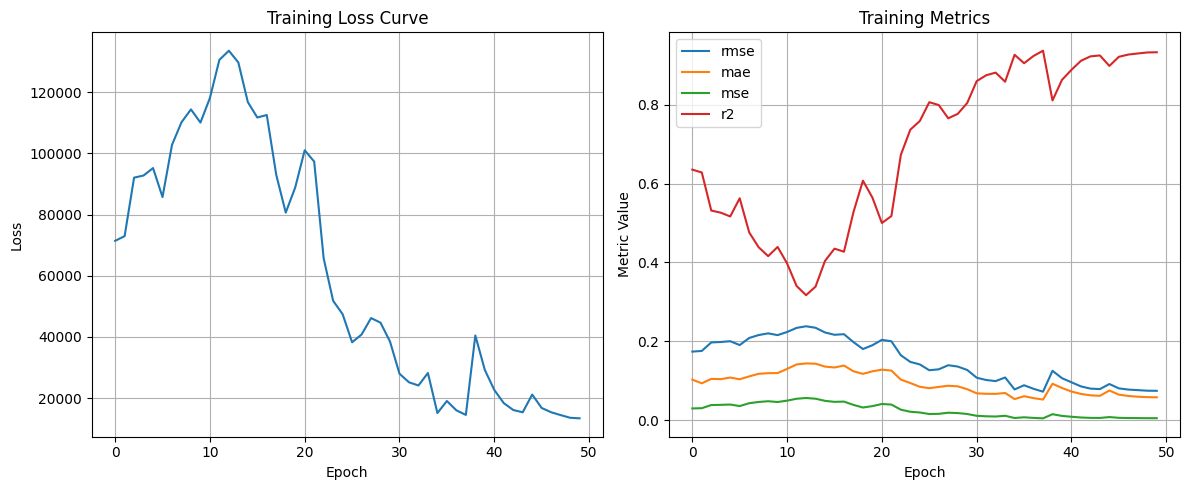

In [416]:
plot_training_history(
    train_results['train_loss'],
    {
        'rmse': train_results['train_rmse'],
        'mae': train_results['train_mae'],
        'mse': train_results['train_mse'],
        'r2': train_results['train_r2'],
    }
)

In [377]:
len(test_loader)

113

In [417]:
# model.load_state_dict(torch.load('best_r2_model.pth', weights_only=True))

def test(
    model,
    test_loader,
    device,
):
    model.eval()

    test_preds = []
    test_targets = []

    test_r2 = []
    test_mae = []
    test_mse = []
    test_rmse = []
    
    with torch.no_grad():
        for data, labels in tqdm(test_loader):
            data = data.to(device)
            labels = labels.to(device)
            predictions = model(data).flatten()
            
            # predictions = torch.cummin(predictions.flip(0), dim=0).values.flip(-1)

            test_preds.append(predictions)
            test_targets.append(labels)

        test_preds = torch.cat(test_preds).cpu().detach().numpy()
        test_targets = torch.cat(test_targets).cpu().detach().numpy()

        mse = mean_squared_error(test_targets, test_preds)

        test_r2.append(r2_score(test_targets, test_preds))
        test_mae.append(mean_absolute_error(test_targets, test_preds))
        test_mse.append(mse)
        test_rmse.append(np.sqrt(mse))

    return {
        'test_r2': test_r2,
        'test_mae': test_mae,
        'test_mse': test_mse,
        'test_rmse': test_rmse,
        'test_preds': test_preds,
        'test_targets': test_targets,
    }
          

In [418]:
test_results = test(model, test_loader, device)

test_results

100%|██████████| 113/113 [00:00<00:00, 174.12it/s]


{'test_r2': [0.1718114612563425],
 'test_mae': [0.16173251],
 'test_mse': [0.03969033],
 'test_rmse': [0.19922432],
 'test_preds': array([ 0.580876  ,  0.6237904 ,  0.6354144 , ...,  0.04349749,
        -0.05631678, -0.03484212], dtype=float32),
 'test_targets': array([[0.99962103],
        [0.9994105 ],
        [0.9992    ],
        ...,
        [0.24190493],
        [0.24169439],
        [0.24148385]], dtype=float32)}

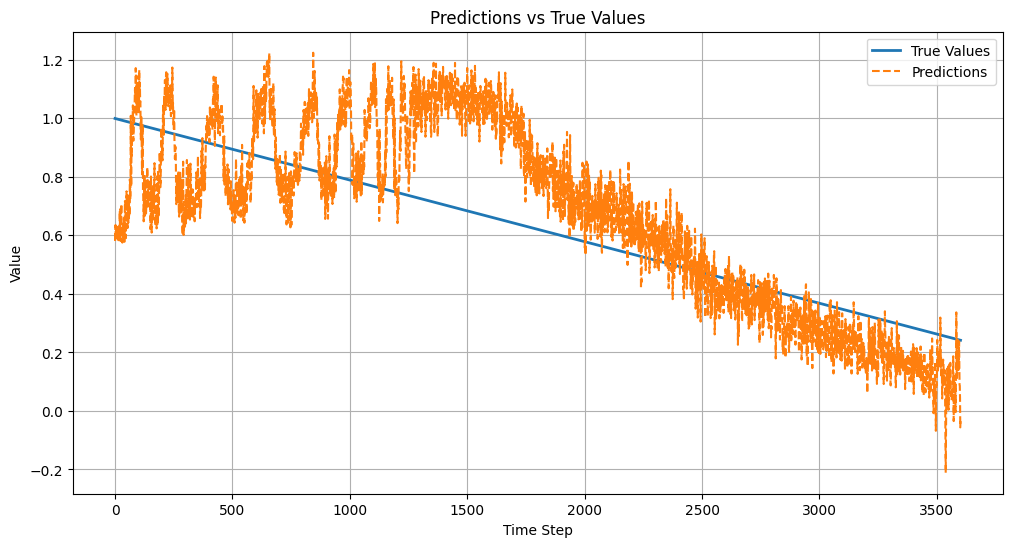

In [420]:
plot_predictions_vs_actuals(
    test_results['test_targets'],
    test_results['test_preds']
)

In [ ]:
test_results['test_targets']

(4602, 1)

In [300]:
test_results['test_preds']

array([0.02777791, 0.02777791, 0.02777791, ..., 0.02777791, 0.02777791,
       0.02777791], dtype=float32)

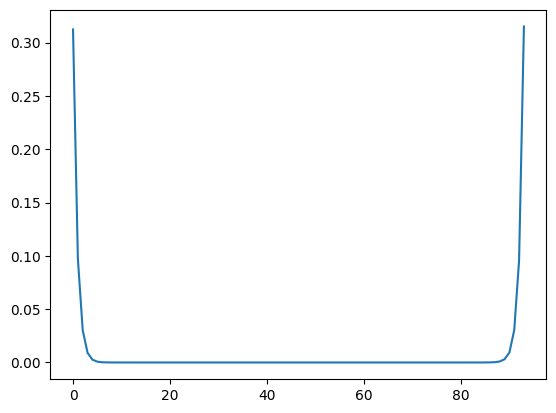

In [151]:
plt.plot(test_results['rul'].cpu().numpy())